## Predicting Mortgage Default in Loan Marketplace

In this notebook you will learn how to build a predictive model with Spark machine learning API (SparkML) and deploy it for scoring in Machine Learning (ML).

This notebook walks you through these steps:

    - Build a model with SparkML API
    - Save the model in the ML repository
    - Create a Deployment in ML (via UI)
    - Test the model (via UI)

In [7]:
# Check Python version. This notebook is implemented for Python 3.5.x. Not all cells may work in other versions of Python.
import platform
print(platform.python_version())

3.6.6


In [8]:
import ibm_db
import pandas
import ibm_db_dbi

### Step 1: Load data  --- Update the *dsn_hostname* value with your Web Console IP

In [9]:
#Enter the values for you database connection
dsn_driver   = "IBM DB2 ODBC DRIVER"
dsn_database = "MORTGAGE"            # e.g. "MORTGAGE"
dsn_hostname = "<Hostname/IP>"       # e.g. "Use the same IP as Web Console"
dsn_port     = "50000"               # e.g. "50000" 
dsn_protocol = "TCPIP"               # i.e. "TCPIP"
dsn_uid      = "db2inst1"            # e.g. "dash104434"
dsn_pwd      = "password"            # e.g. "7dBZ3jWt9xN6$o0JiX!m"

In [10]:
dsn = (
    "DRIVER={{IBM DB2 ODBC DRIVER}};"
    "DATABASE={0};"
    "HOSTNAME={1};"
    "PORT={2};"
    "PROTOCOL=TCPIP;"
    "UID={3};"
    "PWD={4};").format(dsn_database, dsn_hostname, dsn_port, dsn_uid, dsn_pwd)

conn = ibm_db.connect(dsn, "", "")

In [11]:
pconn = ibm_db_dbi.Connection(conn)
df = pandas.read_sql('SELECT * FROM db2inst1.mortgage_join', pconn)

In [12]:
from pyspark.sql import SQLContext
SQLContext = SQLContext(sc)

sdf = SQLContext.createDataFrame(df)
sdf.show()

+----------------+------+--------------+---------+---------------+---------------+-----------+---------+-------------+-----------+----------+--------+
|MORTGAGE_DEFAULT|INCOME|APPLIED_ONLINE|RESIDENCE|YRS_CURRENT_ADD|YRS_CURRENT_EMP|NO_OF_CARDS|CARD_DEBT|CURRENT_LOANS|LOAN_AMOUNT|SALE_PRICE|LOCATION|
+----------------+------+--------------+---------+---------------+---------------+-----------+---------+-------------+-----------+----------+--------+
|               N| 43593|             Y|        O|             13|              0|          1|     2315|            0|      12820|    180000|     130|
|               Y| 45706|             Y|        O|             17|             16|          2|      373|            1|       7275|    145000|     100|
|               N| 44202|             Y|        O|              8|              0|          2|      748|            0|      10455|    170000|     100|
|               N| 43800|             Y|        O|              0|              4|          2|

### Step 2: Build the Spark pipeline and the Random Forest model

In [13]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

# Prepare string variables so that they can be used by the decision tree algorithm
# StringIndexer encodes a string column of labels to a column of label indices
SI1 = StringIndexer(inputCol='APPLIED_ONLINE',outputCol='AppliedOnlineEncoded')
SI2 = StringIndexer(inputCol='RESIDENCE',outputCol='ResidenceEncoded')
labelIndexer = StringIndexer(inputCol='MORTGAGE_DEFAULT', outputCol='label').fit(sdf)

# Pipelines API requires that input variables are passed in  a vector
assembler = VectorAssembler(inputCols=["AppliedOnlineEncoded", "ResidenceEncoded", "INCOME", "YRS_CURRENT_ADD", \
                                       "YRS_CURRENT_EMP", "NO_OF_CARDS", "CARD_DEBT", "CURRENT_LOANS", "LOAN_AMOUNT", \
                                       "SALE_PRICE", "LOCATION"], outputCol="features")

In [14]:
# instantiate the algorithm, take the default settings
rf=RandomForestClassifier(labelCol="label", featuresCol="features")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

pipeline = Pipeline(stages=[SI1,SI2,labelIndexer, assembler, rf, labelConverter])

In [15]:
# Split data into train and test datasets
train, test = sdf.randomSplit([0.8,0.2], seed=11)
train.cache()
test.cache()

DataFrame[MORTGAGE_DEFAULT: string, INCOME: bigint, APPLIED_ONLINE: string, RESIDENCE: string, YRS_CURRENT_ADD: bigint, YRS_CURRENT_EMP: bigint, NO_OF_CARDS: bigint, CARD_DEBT: bigint, CURRENT_LOANS: bigint, LOAN_AMOUNT: bigint, SALE_PRICE: bigint, LOCATION: bigint]

In [16]:
# Build models
model = pipeline.fit(train)

In [17]:
model.transform(test)

DataFrame[MORTGAGE_DEFAULT: string, INCOME: bigint, APPLIED_ONLINE: string, RESIDENCE: string, YRS_CURRENT_ADD: bigint, YRS_CURRENT_EMP: bigint, NO_OF_CARDS: bigint, CARD_DEBT: bigint, CURRENT_LOANS: bigint, LOAN_AMOUNT: bigint, SALE_PRICE: bigint, LOCATION: bigint, AppliedOnlineEncoded: double, ResidenceEncoded: double, label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double, predictedLabel: string]

### Step 3: Score the test data set

In [18]:
results = model.transform(test)
results=results.select(results["MORTGAGE_DEFAULT"],results["label"],results["predictedLabel"],results["prediction"],results["probability"])
results.toPandas().head(6)

,MORTGAGE_DEFAULT,label,predictedLabel,prediction,probability
0,N,0.0,N,0.0,"[0.7108159581284146, 0.28918404187158553]"
1,Y,1.0,N,0.0,"[0.5483901181770174, 0.45160988182298256]"
2,Y,1.0,Y,1.0,"[0.4829334336771619, 0.5170665663228381]"
3,Y,1.0,N,0.0,"[0.6096312853562669, 0.3903687146437331]"
4,N,0.0,N,0.0,"[0.6589100030111489, 0.3410899969888511]"
5,Y,1.0,Y,1.0,"[0.39675351423825006, 0.6032464857617499]"


### Step 4: Model Evaluation

In [19]:
accuracy=results.filter(results.label == results.prediction).count() / float(results.count())
print('Accuracy = {:.2f}.'.format(accuracy))

Accuracy = 0.68.


In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")
print('Area under ROC curve = {:.2f}.'.format(evaluator.evaluate(results)))

Area under ROC curve = 0.65.


### Step 5: Save Model in ML repository

In [21]:
from dsx_ml.ml import save

model_name = "Mortgage_Prediction_Model"
save(name = model_name,
     model = model,
     algorithm_type = 'Classification',
     test_data = test)

Using TensorFlow backend.


{'path': '/user-home/999/DSX_Projects/sanjitc/models/Mortgage_Prediction_Model/1',
 'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python36/spark-2.3/sanjitc/Mortgage_Prediction_Model/1'}

In [22]:
# Write the test data to a .csv so that we can later use it for Evaluation
writeCSV=test.toPandas()
writeCSV.to_csv('../datasets/MortgagePredictionModelEval.csv', sep=',', index=False)

### Step 6: Test Saved Model with Test UI

1. Save the notebook and switch to the Models tab of the project (hint: right click the project name link, mortgage_data, at the top, and open with another tab in your browser).
2. Under Models, find and click into your saved model.
3. Click the Test link to *Real-time score* the model. You can use the data for testing that already loaded: 
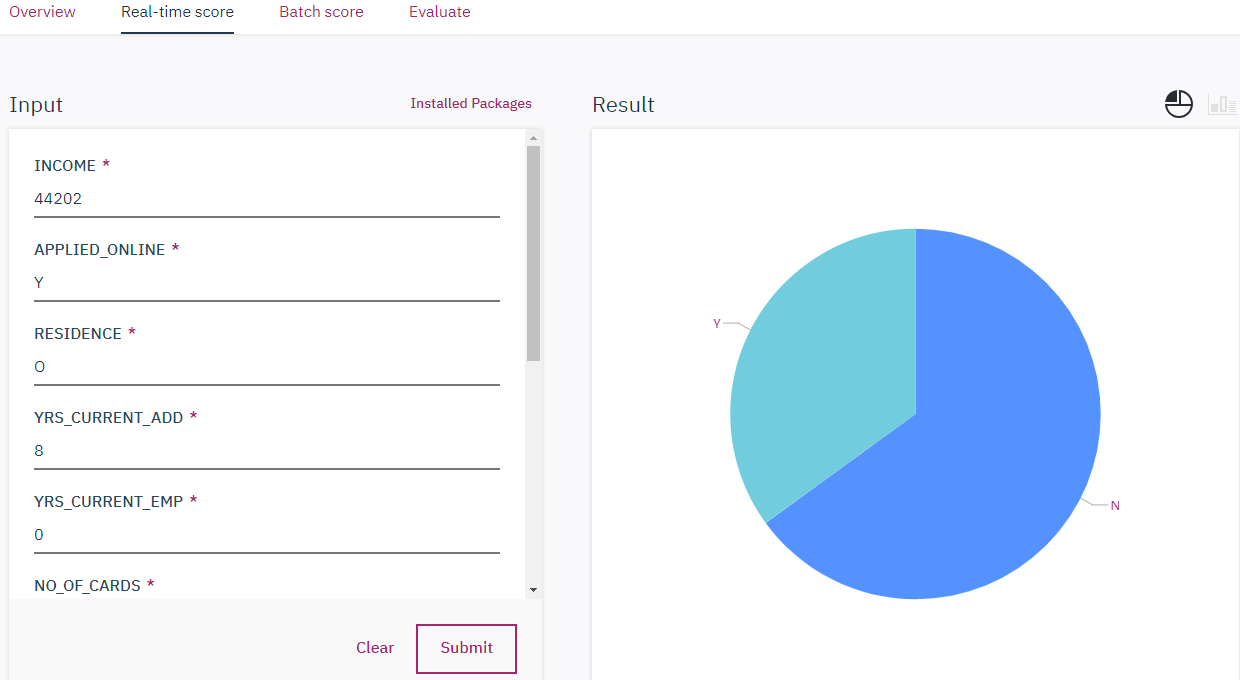

### Summary

You have finished working on this hands-on lab. In this notebook you created a model using SparkML API, 
deployed it in Machine Learning service for online (real time) scoring and tested it using a test client. 

Created by Sanjit Chakraborty
sanjitc@us.ibm.com
Dec 2, 2018